In [1]:
#pyWavelet mods
import picklayers
import calcpulse
import snowradar

#Community packages
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import h5py

from scipy import signal

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [3]:
radar_file = "./data/awi/Data_20170410_01_006.mat"
radar_dat = snowradar.AWI(radar_file, l_case='full')

In [4]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.028389437310606058
0.075697595645


In [5]:
def RadarWindow(x,window_len=11):
    y = np.convolve(signal.windows.boxcar(window_len)/signal.windows.boxcar(window_len).sum(),x,mode='valid')
    return y

In [7]:
#radar_sub = np.transpose(radar_dat.data_radar)[1000:5000,0:300]
radar_sub = np.transpose(radar_dat.data_radar)[1000:6000,0:300]

#radar_sub = np.transpose(radar_dat.data_radar)
radar_1d_smooth = np.apply_along_axis(RadarWindow, 0, radar_sub, 5)
radar_2d_smooth = signal.medfilt2d(radar_sub, kernel_size=5)
#radar_1d_window = RadarWindow(radar_sub,10)

In [8]:
#radar_sub = np.transpose(radar_dat.data_radar)[1000:5000,0:300]
meansignal = radar_sub.mean(axis=1) 

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


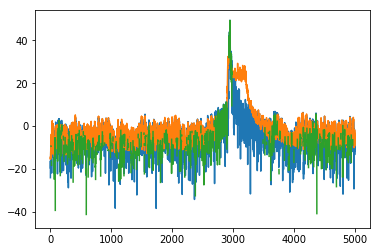

In [9]:
col_idx = 150
fig, ax = plt.subplots()
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,1]))
ax.plot(10*np.log10(meansignal))
ax.plot(10*np.log10(radar_sub[:,1]-meansignal))
#ax.plot(10*np.log10(t))
plt.show()

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


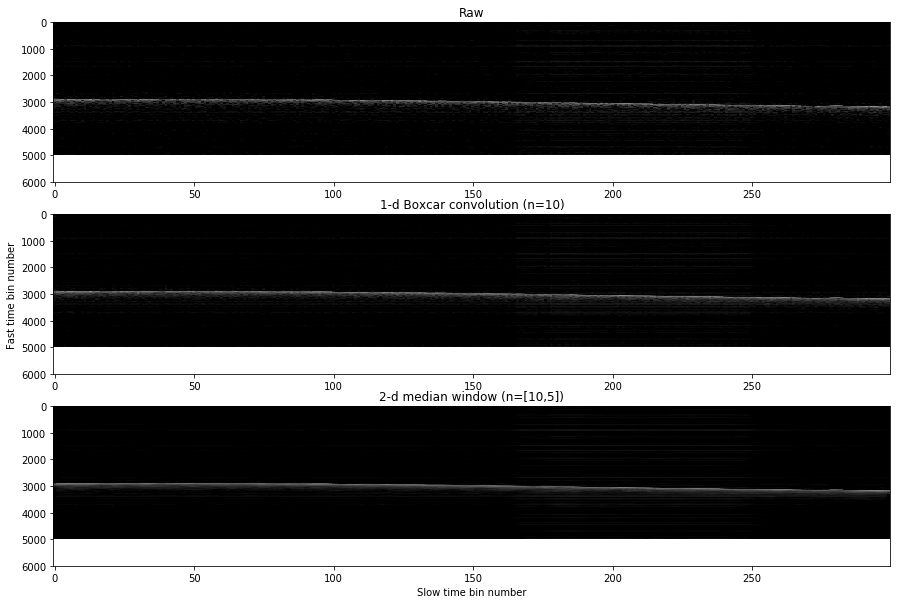

In [10]:
ymin = 0
ymax = 6000
vis_max = 80
vis_min = 0

fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].set_title("Raw")
ax[0].imshow(10 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[0].set_aspect('auto')
ax[0].set_ylim([ymax, ymin])
ax[1].set_ylabel("Fast time bin number")
ax[1].set_title("1-d Boxcar convolution (n=10)")
ax[1].imshow(10 * np.log10(radar_1d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[1].set_aspect('auto')
ax[1].set_ylim([ymax, ymin])
ax[2].set_title("2-d median window (n=[10,5])")
ax[2].imshow(10 * np.log10(radar_2d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[2].set_aspect('auto')
ax[2].set_ylim([ymax, ymin])
ax[2].set_xlabel("Slow time bin number")

plt.show()

In [11]:
l_as,l_si = np.apply_along_axis(picklayers.picklayers, 0, radar_1d_smooth,radar_dat.n2n,radar_dat.dfr,n_snow)

Mean snow depth (m): 0.169758937422249


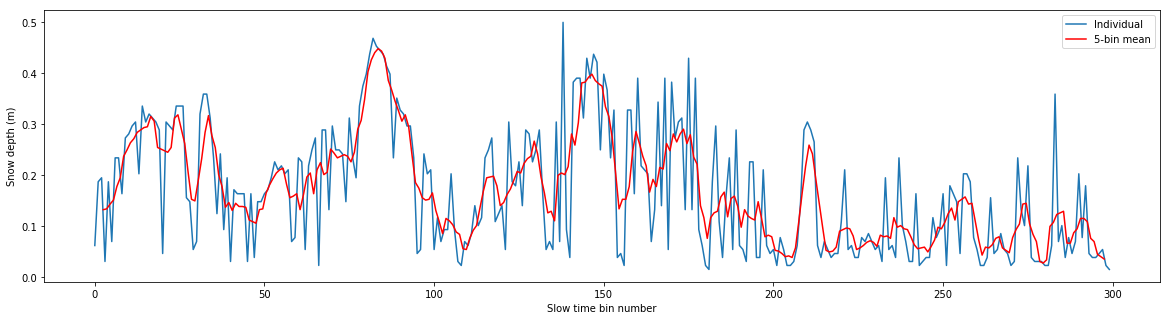

In [12]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow

N = 5
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Mean snow depth (m):", np.mean(snow_depth))
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(snow_depth)
#ax.plot(np.arange(0, len(snow_depth_rollin)),snow_depth_rollin, color='r')
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
plt.show()

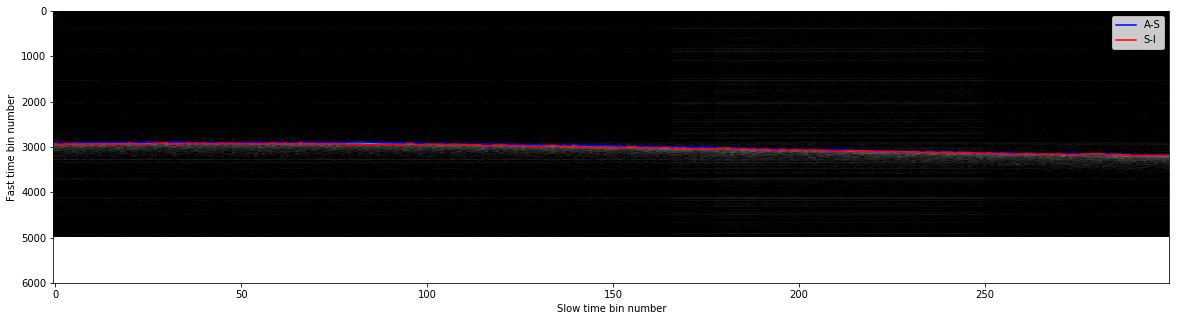

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(10 * np.log10(radar_1d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.set_ylabel("Fast time bin number")
ax.set_xlabel("Slow time bin number")
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_ylim([ymax, ymin])
ax.set_aspect('auto')
plt.show()

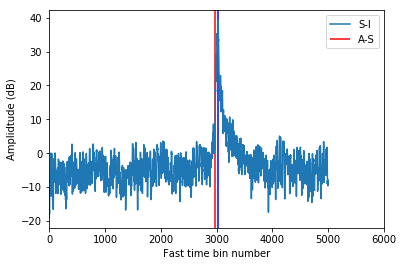

In [15]:
col_idx = 150
fig, ax = plt.subplots()
#ax.plot(data_col)
ax.plot(10*np.log10(radar_1d_smooth[:,col_idx]))
ax.vlines([l_as[col_idx], l_si[col_idx]], 0, 1, transform=ax.get_xaxis_transform(), colors=['r','b'])
#ax.vlines([l_si[col_idx]], 0, 1, transform=ax.get_xaxis_transform(), colors='r')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(["S-I","A-S"],loc="upper right")
ax.set_xlim([ymin, ymax])
plt.show()